# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, inspired by the [Evol Instruct](https://arxiv.org/abs/2304.12244) paper.



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant

In [2]:
!pip install -qU pymupdf ragas

We'll need to provide our LangSmith API key, and set tracing to "true".

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"
print(os.environ["LANGCHAIN_PROJECT"])

AIM - SDG - bcf0c8b4


OpenAI's API Key!

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 2: Loading Source Documents

In order to create a synthetic dataset, we must first load our source documents!

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader

documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [11]:
len(documents)

28

## Task 3: Generate Synthetic Data

Let's first take a peek under the RAGAS hood to see what's happening when we generate a single example.

For simplicities sake - we'll look at a flow that results in a reasoning question.

### Two LLMs To Rule Them All

- `generator_llm` - will generate our seed questions and evolutions
- `critic_llm` - will act as a critic to verify if the evolutions are as we expect them to be

### Entering the Generation

We'll enter the generation process with our `generate_with_langchain_docs()` method - let's look at how that is implemented:

```python
def generate_with_langchain_docs(
    self,
    documents: t.Sequence[LCDocument],
    test_size: int,
    distributions: t.Optional[Distributions] = None,
    with_debugging_logs=False,
    is_async: bool = True,
    raise_exceptions: bool = True,
    run_config: t.Optional[RunConfig] = None,
):
    distributions = distributions or {}
    # chunk documents and add to docstore
    self.docstore.add_documents(
        [Document.from_langchain_document(doc) for doc in documents]
    )

    return self.generate(
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=with_debugging_logs,
        is_async=is_async,
        raise_exceptions=raise_exceptions,
        run_config=run_config,
    )
```

As you can see - before we do anything, our `doctore` is created using the provided `documents`.

Then, we move on to `generate()`, let's see how that works next!

### Generating Examples!

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/generator.py#L234), we'll work through the pseudo-code.

```python
function generate(test_size, distributions, other_params...):
    # Validate and set default values
    if distributions not provided:
        distributions = DEFAULT_DISTRIBUTION
    
    validate_distributions_sum_to_one(distributions)
    
    set_up_run_config()
    initialize_docstore()
    
    # Initialize evolutions
    for each evolution in distributions:
        initialize_evolution(evolution)
    
    set_up_debugging_logs_if_needed()
    
    # Set up execution environment
    executor = create_executor()
    
    # Get initial nodes
    current_nodes = get_random_nodes_from_docstore(test_size)
    
    total_evolutions = 0
    
    # Distribute evolutions based on probabilities
    for each evolution, probability in distributions:
        num_samples = round(probability * test_size)
        for i in random_sample(range(test_size), num_samples):
            submit_task_to_executor(evolution.evolve, current_nodes[i])
            total_evolutions += 1
    
    # Add filler evolutions if needed
    while total_evolutions < test_size:
        random_evolution = choose_random_evolution(distributions)
        submit_task_to_executor(random_evolution.evolve, current_nodes[total_evolutions])
        total_evolutions += 1
    
    # Get results
    try:
        test_data_rows = executor.get_results()
        if test_data_rows is empty:
            raise Exception("No results generated")

    return test_data_rows
```

In essence, we:

1. Do some validation of inputs, and initialize our evolutions.
2. Get some random nodes from our docstore.
3. Evolve the current nodes based on the desired distribution.
4. Fill with sampled evolutions if we're not at the desired number of rows.

### Peeking into the Complex Evolution Implementation for Reasoning Questions.

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L375). We'll work through the high-level implementation below.

Let's look into how the "Complex Evolution" is implemented:

1. First, we use [`_aevolve()`](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L289) to generate a "Seed Question".

```python
simple_question, current_nodes, _ = await self.se._aevolve(
            current_tries, current_nodes
        )
```

2. We use our provided `question_prompt` to generate a reasoning question.

```python
result = await self.generator_llm.generate(
            prompt=question_prompt.format(
                question=simple_question, context=merged_node.page_content
            )
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L15)):

```python
instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question."""
```

3. We verify the question is valid.

```python
is_valid_question, feedback = await self.question_filter.filter(
            reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L390))

```python
instruction="""
Asses the given question for clarity and answerability given enough domain knowledge, consider the following criteria:
1.Independence: Can the question be understood and answered without needing additional context or access to external references not provided within the question itself? Questions should be self-contained, meaning they do not rely on specific documents, tables, or prior knowledge not shared within the question.
2.Clear Intent: Is it clear what type of answer or information the question seeks? The question should convey its purpose without ambiguity, allowing for a direct and relevant response.
Based on these criteria, assign a verdict of "1" if a question is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. Assign "0" if it fails to meet one or more of these criteria due to vagueness, reliance on external references, or ambiguity in intent.
Provide feedback and a verdict in JSON format, including suggestions for improvement if the question is deemed unclear. Highlight aspects of the question that contribute to its clarity or lack thereof, and offer advice on how it could be reframed or detailed for better understanding and answerability.
"""
```

4. We [handle the question](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L401) if it's not valid, otherwise we compress the question:

```python
compressed_question = await self._transform_question(
            prompt=self.compress_question_prompt, question=reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L100))

```python
instruction="""Rewrite the following question to make it more indirect and shorter while retaining the essence of the original question.
    The goal is to create a question that conveys the same meaning but in a less direct manner. The rewritten question should shorter so use abbreviation wherever possible."""
```

5. Filter the newly compressed question based on a comparison to the original simple question.

```python
if await self.evolution_filter.filter(simple_question, compressed_question):
            # retry
            current_nodes = self.se._get_new_random_node()
            logger.debug(
                "evolution_filter failed, retrying with %s", len(current_nodes.nodes)
            )
            return await self.aretry_evolve(current_tries, current_nodes)
```

`filter` is implemented as follows, with our Critic LLM:

```python
    async def filter(self, simple_question: str, compressed_question: str) -> bool:
        prompt = self.evolution_elimination_prompt.format(
            question1=simple_question, question2=compressed_question
        )
        results = await self.llm.generate(prompt=prompt)
        results = results.generations[0][0].text.strip()
        results = await evolution_elimination_parser.aparse(results, prompt, self.llm)
        results = results.dict() if results is not None else {}
        logger.debug("evolution filter: %s", results)
        return results.get("verdict") == 1
```

Let's zoom back out now!



### Generating Answers:

For answer generation, we simply ask the LLM to answer the question we evolved using the context associated with our evolution - that's it!

We will this:

```python
class AnswerFormat(BaseModel):
    answer: str
    verdict: int
```

Using [this prompt](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L143):

```python
instruction="""Answer the question using the information from the given context. Output verdict as '1' if answer is present '-1' if answer is not present in the context."""
```

This uses our Generator LLM.

Actually creating our Synthetic Dataset is as simple as running the following cell!

In [12]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

#### ❓ Question #1:

What do the distributions do *specifically*?

> NOTE: More information is available [here](https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution) on the evolution distributions.

Let's generate!

> NOTE: This cell will take some time, and also make a lot of calls to OpenAI's endpoints! You may run into rate-limits during this cell!

In [ ]:
# I ran this cell before with debugging log == True. It generated to many lines. so I just deleted that cell and leave this command here.
# I have saved the log in the folder if you want to have a look. 
testset = generator.generate_with_langchain_docs(documents, 20, distributions, with_debugging_logs=True)

#### 🏗️ Activity #1:

Using the dubgging logs above - trace through a single example of an evolution.

Mark which LLM (Generator, or Critic) was responsible for each step.

1. It started from gettiing "context score" (chunk validation):

[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 3.0}

2. It showed the keyphrases in the merged document nodes as below:

[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Forward-looking statements', 'Financial condition', 'Results of 
operations', 'Product introductions', 'Macroeconomic conditions']

3. It generated seed question as below:

[ragas.testset.evolutions.INFO] seed question generated: What are forward-looking statements and how do they relate to the 
content of Form 10-Q?

4. It started multicontext evolution:

[ragas.testset.evolutions.DEBUG] [MultiContextEvolution] multicontext question generated: "What type of forward-looking statements 
are typically included in a Form 10-Q for a company like Apple Inc.?"

5. it valided the evolved question:

[ragas.testset.filters.DEBUG] filtered question: {'feedback': "The question asks about the types of forward-looking statements 
typically included in a Form 10-Q for a company like Apple Inc. It is specific in its focus on forward-looking statements and the 
context of a Form 10-Q, which is a quarterly report filed by publicly traded companies. However, the question could be improved by 
clarifying what is meant by 'forward-looking statements' and possibly providing examples or categories of such statements. This would 
enhance understanding for those who may not be familiar with the terminology or the specific content of a Form 10-Q. Overall, the 
question is mostly clear and answerable, but slight adjustments could improve its clarity.", 'verdict': 1}

6. It compressed the evolved question:

[ragas.testset.evolutions.DEBUG] [MultiContextEvolution] multicontext question compressed: "What forward-looking statements 
are in Apple Inc.'s Form 10-Q?"

7. It evaluated the compressed question based on a comparison to the original simple question. I didn't find the log for the specific question, but it should be something like this, where it compares the compressed evoloved questions VS the original question:

[ragas.testset.filters.DEBUG] evolution filter: {'reason': "Both questions ...."}

8. It generated the answer for the question:

[ragas.testset.evolutions.DEBUG] answer generated: {'answer': "The Form 10-Q of Apple Inc. contains forward-looking statements that 
provide current expectations of future events based on certain assumptions. 
These statements include discussions on the potential future impact of macroeconomic conditions on the company's business 
and results of operations.", 'verdict': 1}

In [22]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How can the materialization of risks affect th...,"[ ended March 30, 2024 (the “second quarter 20...",When any one or more of the risks disclosed in...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
1,How can the materialization of risks affect th...,"[ ended March 30, 2024 (the “second quarter 20...",The materialization of risks can materially an...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
2,What are the key requirements and implications...,"[Segment Reporting\nIn November 2023, the FASB...","ASU No. 2023-07, Segment Reporting (Topic 280)...",simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
3,How does Apple Inc. manage foreign exchange ra...,"[ of reasons, including accounting considerati...",Apple Inc. manages foreign exchange rate risk ...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
4,What are examples of activities categorized un...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...,Examples of activities categorized under inves...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
5,How can macroeconomic conditions impact a comp...,[Item 2. \nManagement’s Discussion and Analysi...,"Macroeconomic conditions, including inflation,...",simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
6,What is the purpose of a Form 10-Q quarterly r...,[UNITED STATES\nSECURITIES AND EXCHANGE COMMIS...,The purpose of a Form 10-Q quarterly report fi...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
7,How did net sales for Services change during t...,[Products and Services Performance\nThe follow...,Services net sales increased during the third ...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
8,What is the purpose of the certification provi...,"[Exhibit 31.2\nCERTIFICATION\nI, Luca Maestri,...",The purpose of the certification provided by L...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
9,What is the impact of other comprehensive inco...,[Apple Inc.\nCONDENSED CONSOLIDATED STATEMENTS...,The impact of other comprehensive income/loss ...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True


# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [23]:
from langsmith import Client

client = Client()

dataset_name = "Apple 10-Q Filing Questions - v3"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Apple's 10-Q Filing"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [24]:
for test in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": test[1]["question"]
      },
      outputs={
          "answer": test[1]["ground_truth"]
      },
      metadata={
          "context": test[0]
      },
      dataset_id=dataset.id
  )

## Basic RAG Chain

Time for some RAG!

We'll use the Apple 10-Q filing as our data source today!


In [25]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [26]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [27]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [28]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q"
)

In [29]:
retriever = vectorstore.as_retriever()

To get the "A" in RAG, we'll provide a prompt.

In [30]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [31]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [32]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [33]:
rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"I don't know."

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [34]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [35]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        }
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

## LangSmith Evaluation

In [36]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain"},
)

View the evaluation results for experiment: 'whispered-name-46' at:
https://smith.langchain.com/o/e8fff0bf-5e2d-5959-8289-a4e1b2625f84/datasets/3b6587cd-e05e-4680-b291-75852e7efe77/compare?selectedSessions=115c2e2a-e88b-4565-9c4d-44eca8069038




0it [00:00, ?it/s]

<ExperimentResults whispered-name-46>

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [37]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [38]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

In [40]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

In [41]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q (Augmented)"
)

In [42]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [43]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [44]:
dope_rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

'Yo, based on the context, Apple is looking pretty solid! Their net income for the nine months ended June 29, 2024, is $79 billion, up from $74 billion the previous year. They’ve got a decent cash flow from operating activities, and their gross margin is on the rise. Sure, total assets have dipped a bit, but overall, they’re still raking in the dough. So yeah, Apple seems to be cruising along nicely in the financial health lane! 🍏💰'

Finally, we can evaluate the new chain on the same test set!

In [45]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'fixed-station-47' at:
https://smith.langchain.com/o/e8fff0bf-5e2d-5959-8289-a4e1b2625f84/datasets/3b6587cd-e05e-4680-b291-75852e7efe77/compare?selectedSessions=c125913f-cab8-4602-9e31-31e77ce39979




0it [00:00, ?it/s]

<ExperimentResults fixed-station-47>

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

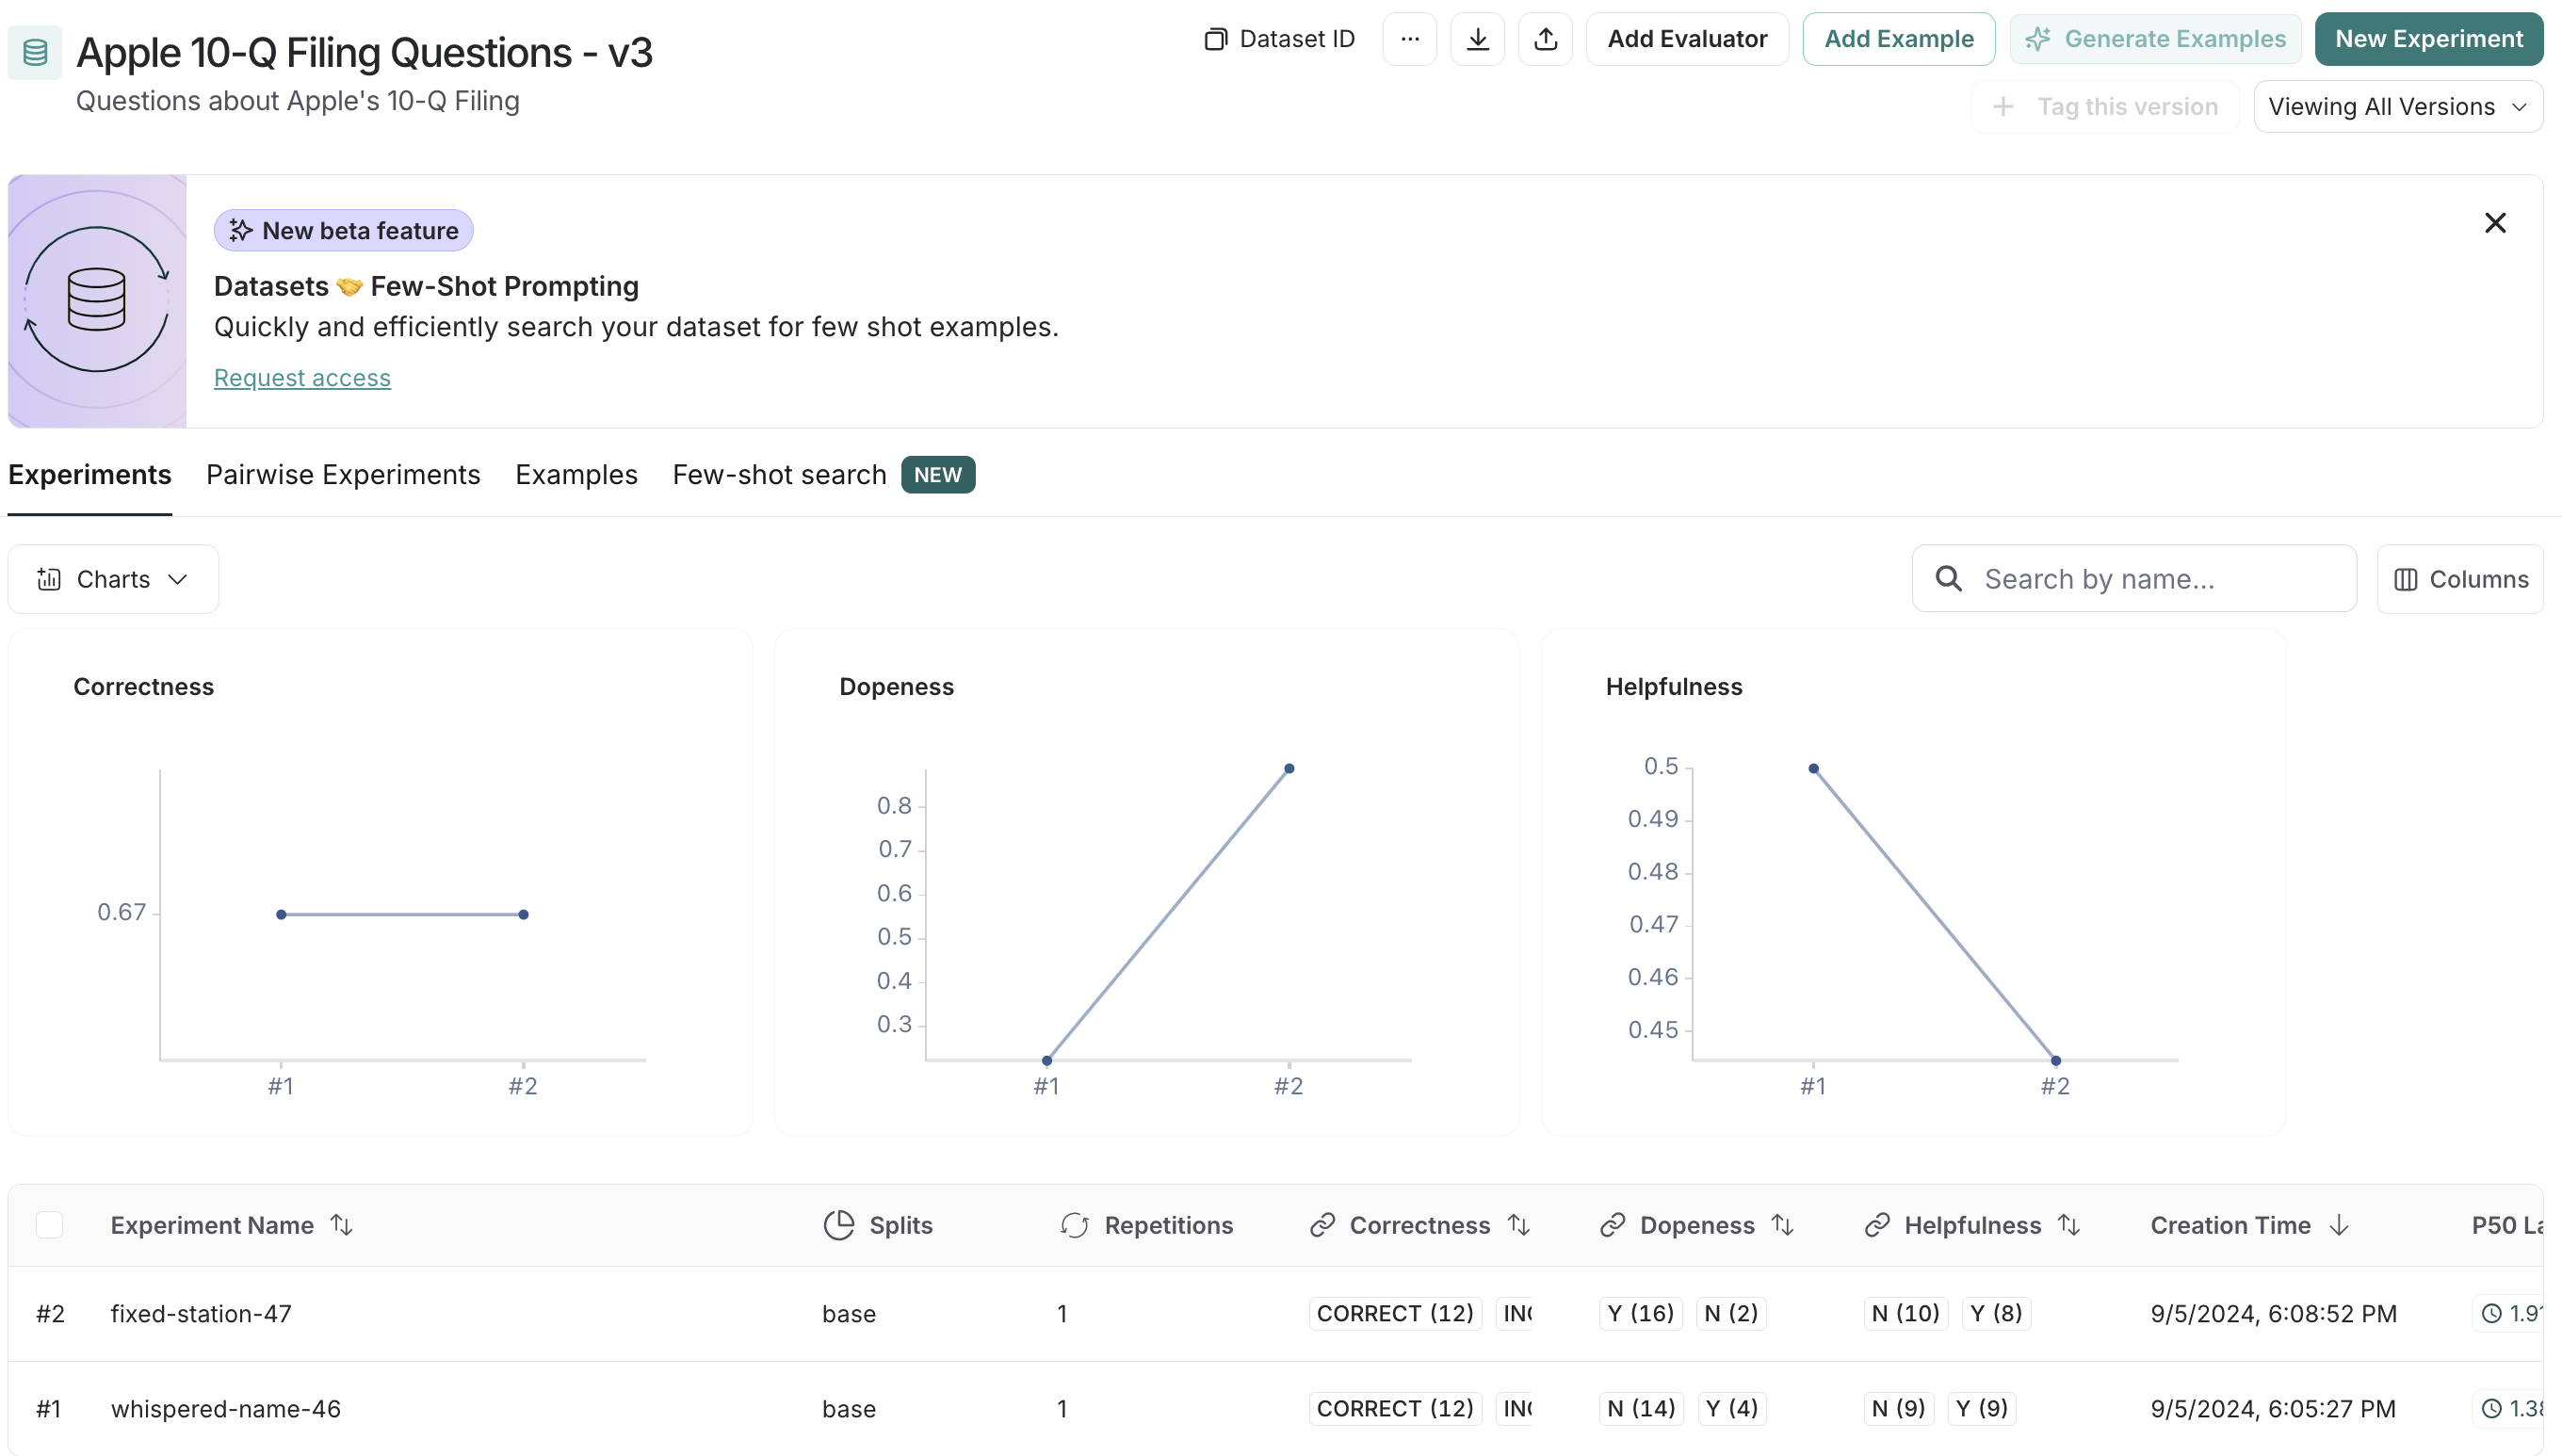